In [1]:
import math
import os
import torch
import torch.distributions.constraints as constraints
import pyro
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO, config_enumerate, TraceEnum_ELBO, infer_discrete
import pyro.distributions as dist

import matplotlib.pyplot as plt

from pyro import poutine

In [2]:
#### Initialization
# enable validation (e.g. validate parameters of distributions)
assert pyro.__version__.startswith('1.5.1')
pyro.enable_validation(True)

# random seeding
pyro.set_rng_seed(101)
torch.manual_seed(123)

# clear the param store in case we're in a REPL
pyro.clear_param_store()


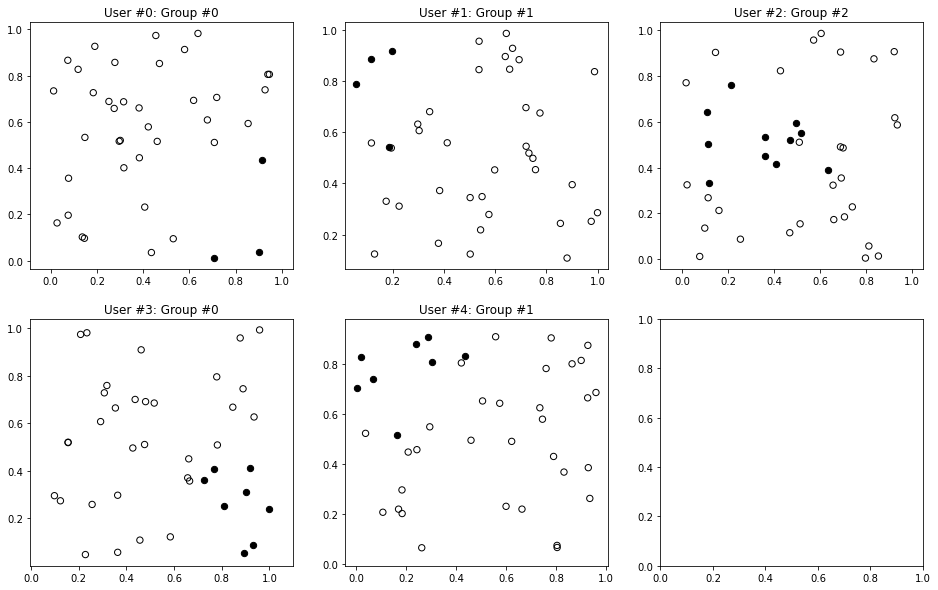

In [3]:
#### Data generation
n_groups = 3
n_clust = 1
n_users = 5
n_items = 40
d_kpi = 2

large_num = 50

def gen_items(n_users, n_items, d_kpi):
    user_items = []
    for _ in range(n_users):
        user_items.append(torch.rand(n_items, d_kpi))
    return user_items

user_items = gen_items(n_users, n_items, d_kpi)

def get_theta(x, center, scale, large_num=large_num):
    dist = torch.pow(torch.sum(torch.pow((center - x), 2), dim=1), 0.5)
    inv_prob = 1. - (1./(1. + torch.exp((dist - scale)*large_num)))
    return 1. - (n_clust/torch.sum(1./inv_prob, dim=0)) # using harmonious mean

def gen_data(true_beta, true_scale, user_items):
    '''
    inputs:
        true_beta: 2D torch tensor of size n_groups-by-d_kpi (implicit param)
        true_scale: 1D torch tensor of length n_groups
        user_items: list (size-n_users) of 
            2D torch tensor of size n_items-by-d_kpi (implicit param)
    '''
    n_groups = true_beta.shape[0]
    true_p_grp = torch.ones(n_groups)/n_groups
    n_users = len(user_items)
    user_ID = []
    user_labels = [[] for _ in range(n_users)]
    for i_user in range(n_users):
        # uid = pyro.sample('fix_uid_{}'.format(i_user), dist.Categorical(true_p_grp))
        uid = i_user%n_groups
        user_ID.append(uid)
        center, scale = true_beta[uid], true_scale[uid]
        
        items = user_items[i_user]
        for i_item in range(items.shape[0]):
            user_labels[i_user].append(
                pyro.sample('fix_ulab_{}_{}'.format(i_user, i_item), 
                    dist.Bernoulli(get_theta(items[i_item:i_item+1], center, scale))
                )
            )
    return user_ID, user_labels

true_beta = torch.rand(n_groups, n_clust, d_kpi)
true_scale = 0.3*torch.ones(n_groups, n_clust)
user_ID, user_labels = gen_data(true_beta, true_scale, user_items)

## visualize the data
code_face_c = {0: 'none', 1:'k'}
code_color = {0:'k', 1:'r', 2:'g', 3:'b'}
code_marker = {0:'o', 1:'^'}
msize = 40

fig, axes = plt.subplots(2, 3, figsize=(16, 10))
for i_user in range(3):
    axes[0, i_user].set_title('User #{}: Group #{}'.format(i_user, user_ID[i_user]))
    axes[0, i_user].set(xlim=[0, 1], ylim=[0, 1])
    axes[0, i_user].axis('equal')
    for i_it in range(n_items):
        axes[0, i_user].scatter(user_items[i_user][i_it, 0], user_items[i_user][i_it, 1], color=code_color[0], marker=code_marker[0], s=msize, facecolors=code_face_c[int(user_labels[i_user][i_it])])

for i_user in range(3, n_users):
    i_ax = i_user - 3
    axes[1, i_ax].set_title('User #{}: Group #{}'.format(i_user, user_ID[i_user]))
    axes[1, i_ax].set(xlim=[0, 1], ylim=[0, 1])
    axes[1, i_ax].axis('equal')
    for i_it in range(n_items):
        axes[1, i_ax].scatter(user_items[i_user][i_it, 0], user_items[i_user][i_it, 1], color=code_color[0], marker=code_marker[0], s=msize, facecolors=code_face_c[int(user_labels[i_user][i_it])])

plt.show()
        

In [4]:
#### Define model and guide
n_groups_hat = 3

@config_enumerate(default='sequential')
def model(data):
    user_items, user_labels = data

    true_p_grp = torch.ones(n_groups_hat)/n_groups_hat
    true_beta_hat = pyro.param("true_beta", torch.rand(n_groups_hat, n_clust, d_kpi),
                         constraint=constraints.unit_interval)
    true_scale_hat = pyro.param("true_scale", torch.ones(n_groups_hat, n_clust)*0.3,
                         constraint=constraints.interval(0.1, 0.5))
    # true_scale_hat = true_scale
    large_num_hat = 20 # pyro.param("large_num", torch.ones(10), constraint=constraints.interval(1.0, 100.0))
    # n_users = len(user_items)
    user_ID = []
    # user_labels = [[] for _ in range(n_users)]
    for i_user in range(n_users):
        uid = pyro.sample('uid_{}'.format(i_user), dist.Categorical(true_p_grp))
        user_ID.append(uid)
        center, scale = true_beta_hat[uid], true_scale_hat[uid]
        
        items = user_items[i_user]
        for i_item in range(items.shape[0]):
            label = pyro.sample('ulab_{}_{}'.format(i_user, i_item), 
                dist.Bernoulli(get_theta(items[i_item:i_item+1], center, scale, large_num=large_num_hat)),
                obs=user_labels[i_user][i_item]
            )
            # user_labels[i_user].append(label)
    return user_ID

def guide(data):
    true_p_grp = torch.ones(n_groups_hat)/n_groups_hat
    for i_user in range(n_users):
        uid = pyro.sample('uid_{}'.format(i_user), dist.Categorical(true_p_grp))

# from pyro.infer.autoguide import AutoDelta
# guide = AutoDelta(poutine.block(model, hide=['uid_{}'.format(i_user) for i_user in range(n_users)]))

In [5]:
#### training

data = (user_items, user_labels)

## setup the optimizer
adam_params = {"lr": 0.05, "betas": (0.90, 0.999)}
optimizer = Adam(adam_params)

## collect history
# gradient_norms = defaultdict(list)
# for name, value in pyro.get_param_store().named_parameters():
#     value.register_hook(lambda g, name=name: gradient_norms[name].append(g.norm().item()))

## find best starting point
# n_seeds = 50
# seed_loss = torch.zeros(n_seeds)
# for seed in range(n_seeds):
#     pyro.set_rng_seed(seed)
#     pyro.clear_param_store()
#     ## setup the inference algorithm
#     svi = SVI(model, guide, optimizer, loss=TraceEnum_ELBO(max_plate_nesting=0))
#     seed_loss[seed] = svi.loss(model, guide, data)
# best_seed = seed_loss.argmin()
# print(seed_loss)
# print('best_loss = ', seed_loss.min())
# pyro.set_rng_seed(best_seed)

pyro.clear_param_store()
## setup the inference algorithm
svi = SVI(model, guide, optimizer, loss=TraceEnum_ELBO(max_plate_nesting=0))

n_steps = 2000
n_steps_batch = 100
n_batches = n_steps // n_steps_batch
losses = []

# do gradient steps
# for step in range(n_steps):
#     losses.append(svi.step(data))
#     if step % 100 == 0:
#         print('.', end='')
        

In [6]:
# do batch gradient steps
for i_batch in range(n_batches):

    for step in range(n_steps_batch):
        losses.append(svi.step(data))

    ## plot best results
    beta_hat = pyro.param("true_beta").clone().detach()
    scale_hat = pyro.param("true_scale").clone().detach()

    #### MAP predictor
    # guide_trace = poutine.trace(guide).get_trace(data)  # record the globals
    # trained_model = poutine.replay(model, trace=guide_trace)  # replay the globals

    # def classifier(data, temperature=0):
    #     inferred_model = infer_discrete(trained_model, temperature=temperature,
    #                                     first_available_dim=-2)  # avoid conflict with data plate
    #     trace = poutine.trace(inferred_model).get_trace(data)
    #     return [trace.nodes["uid_{}".format(i)]["value"] for i in range(n_users)]

    # user_ID_hat = classifier(data)

    # user_ID_hat = []
    # user_items, user_labels = data
    # for i_user in range(n_users):
    #     items, labels = user_items[i_user], torch.tensor(user_labels[i_user])
    #     dists = torch.zeros(n_groups_hat)
    #     for i_group in range(n_groups_hat):
    #         dists[i_group] = torch.sum( (torch.sum((items - beta_hat[i_group])**2.0, dim=1))**0.5 * labels ) / torch.sum(labels)
    #     user_ID_hat.append(dists.argmin())
    # print(user_ID_hat)
    user_ID_hat = [0, 1, 2, 0, 1]

    fig, axes = plt.subplots(2, 3, figsize=(16, 10))
    for i_user in range(3):
        gid_hat = int(user_ID_hat[i_user])
        axes[0, i_user].set_title('User #{}: Group #{}'.format(i_user, gid_hat))
        axes[0, i_user].axis('equal')
        for i_it in range(n_items):
            axes[0, i_user].scatter(user_items[i_user][i_it, 0], user_items[i_user][i_it, 1], color=code_color[0], marker=code_marker[0], s=msize, facecolors=code_face_c[int(user_labels[i_user][i_it])])
        axes[0, i_user].scatter(beta_hat[gid_hat, :, 0], beta_hat[gid_hat, :, 1], color=code_color[gid_hat+1], marker=code_marker[1], s=msize*5)
        axes[0, i_user].set(xlim=[0, 1], ylim=[0, 1])

    for i_user in range(3, n_users):
        gid_hat = int(user_ID_hat[i_user])
        i_ax = i_user - 3
        axes[1, i_ax].set_title('User #{}: Group #{}'.format(i_user, gid_hat))
        axes[1, i_ax].axis('equal')
        for i_it in range(n_items):
            axes[1, i_ax].scatter(user_items[i_user][i_it, 0], user_items[i_user][i_it, 1], color=code_color[0], marker=code_marker[0], s=msize, facecolors=code_face_c[int(user_labels[i_user][i_it])])
        axes[1, i_ax].scatter(beta_hat[gid_hat, :, 0], beta_hat[gid_hat, :, 1], color=code_color[gid_hat+1], marker=code_marker[1], s=msize*5)
        axes[1, i_ax].set(xlim=[0, 1], ylim=[0, 1])

    ## print centers   
    axes[1, 1].axis('equal')
    for gid_hat in range(n_groups_hat):
        axes[1, 1].scatter(beta_hat[gid_hat, :, 0], beta_hat[gid_hat, :, 1], color=code_color[gid_hat+1], marker=code_marker[1], s=msize*5)
    axes[1, 1].set(xlim=[0, 1], ylim=[0, 1])

    ## print loss history
    axes[1, 2].plot(losses)
    axes[1, 2].set_title("TraceEnum_ELBO")
    axes[1, 2].set_xlabel("step")
    axes[1, 2].set_ylabel("loss")

    plt.savefig('opt_step_res_{}.png'.format(i_batch))
    plt.close(fig)
    # plt.show()


KeyboardInterrupt: 

Text(0, 0.5, 'loss')

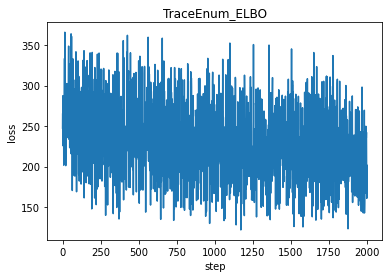

In [7]:
#### post-process

# print loss history
plt.plot(losses)
plt.title("TraceEnum_ELBO")
plt.xlabel("step")
plt.ylabel("loss")


In [8]:
print(beta_hat)
print(scale_hat)

tensor([[[0.4039, 0.6854]],

        [[0.5066, 0.5655]],

        [[0.4969, 0.1600]]])
tensor([[0.2143],
        [0.2097],
        [0.2916]])


In [9]:
#### MAP predictor
guide_trace = poutine.trace(guide).get_trace(data)  # record the globals
trained_model = poutine.replay(model, trace=guide_trace)  # replay the globals

def classifier(data, temperature=0):
    inferred_model = infer_discrete(trained_model, temperature=temperature,
                                    first_available_dim=-1)  # avoid conflict with data plate
    trace = poutine.trace(inferred_model).get_trace(data)
    return [trace.nodes["uid_{}".format(i)]["value"] for i in range(n_users)]

print(classifier(data))



[tensor(1), tensor(2), tensor(2), tensor(0), tensor(1)]
